# What's in this notebook?
The work to develop a classifier can be found here. Using sklearn and nltk, I used features developed through natural language processing, as well as hand-crafted features, in order classify using sklearn models. 

In [1]:
import pandas as pd
import numpy as np
import nltk 
import pickle

In [51]:
# import data
with open('labeled_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [52]:
# get distribution of types of speakers
data.given_by.value_counts()

politician    333
celebrity     247
business      158
academic      102
author        100
journalist     65
faculty        46
military       23
athlete        21
religious      19
student        14
other           1
Name: given_by, dtype: int64

In order to have a better classifier, a few of these need to be combined -- academic and faculty are very closely related, as are journalist and author. So, we'll join those groups together. All other types of speeches will be disregarded, as they are rare. 

In [53]:
data.given_by = data.given_by.apply(lambda x: 'author' if x == 'author' or x == 'journalist' 
                    else 'academic' if x == 'academic' or x == 'faculty' else x)

In [54]:
data.drop(data[data.apply(lambda x: 
                          x.given_by in 
                          ['military', 'athlete', 'religious', 'student', 'other'],
                          axis=1)].index, inplace=True)

In [55]:
data.given_by.value_counts()

politician    333
celebrity     247
author        165
business      158
academic      148
Name: given_by, dtype: int64

In [57]:
data.head()

,source,transcript,processed,given_by
0,https://www.youtube.com/watch?v=bPv21OyQLkM,I'm pleased to welcome to the platform miss Ca...,"[pleased, welcome, platform, miss, carlton, fi...",business
1,https://www.youtube.com/watch?v=ngzIkKtjT6o,author Tom Wolfe addressed the graduating clas...,"[author, tom, wolfe, address, graduate, class,...",author
2,https://www.youtube.com/watch?v=y5YvCbOmNxQ,ladies and gentlemen dr. Fred Rogers Wow it's ...,"[lady, gentlemen, dr, fred, rogers, wow, beaut...",politician
3,https://www.youtube.com/watch?v=Q34H3As2QJA,I'd like to tell you too true stories evening ...,"[like, tell, true, story, evening, together, m...",celebrity
4,https://www.youtube.com/watch?v=abo-YcLrnao,thank you and I'm a doctor so pay attention fo...,"[thank, doctor, pay, attention, cry, loud, tha...",celebrity


## Feature Engineering
Since I already cleaned and tokenized the transcripts in the nlp-eda notebook, we can dive right into feature engineering (phew)!

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
cv = CountVectorizer(ngram_range=(1, 2), max_df = .4, min_df = 25)

In [74]:
bow = cv.fit_transform([' '.join(transcript) for transcript in data.processed.tolist()])

In [80]:
bow.shape

(1051, 6092)

6,092 features is too many features for only 1051 observations! Using LSA (latent semantic analysis), I reduce the dimension of the feature space.

In [103]:
from sklearn.decomposition import TruncatedSVD

def find_num_svd_components(percent_variance):
    """
    Function to find the number of components for SVD that will 
    explain [percent_variance]% of variance.
    """
    n = 0
    svd_sum = 0
    while svd_sum < percent_variance:
        n += 1
        svd = TruncatedSVD(n_components = n)
        bow_transformed = svd.fit_transform(bow)
        svd_sum = sum(svd.explained_variance_ratio_)
    return n

find_num_svd_components(.95)

38

In [104]:
svd = TruncatedSVD(n_components=38)
bow_transformed = svd.fit_transform(bow)

38 components is much better. Now we'll look at how a couple of classifiers perform using SVD-ed count vectors as the only features.

## Modeling (only using count vectorizer features)
We'll take a look at just a few of the basic models -- KNN, random forest, and SVM -- just to see how the classifiers fair. I chose these because they span in complexity of process (KNN is fairly simple, SVM is more complex, random forest is somewhere in between the two).

### Preparing for modeling
Before modeling, we have to label encode the categories, split the data into a training group and testing group, and scale it (doesn't matter/hurt for random forest, but does matter for KNN and SVM). Also, since there's a bit of class imbalance when it comes to politician and celebrity speeches, I undersampled those majority classes at random. 

In [107]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(data.given_by)

In [153]:
# preparing to evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def evaluation(y_test, y_pred):
    print('classification report: \n')
    print(classification_report(y_test, y_pred))
    print("Accuracy score:", accuracy_score(y_test, y_pred))
    
# directly taken from sklearn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [143]:
# scaling 
from sklearn.preprocessing import MaxAbsScaler # this scaler works well w/ sparse matricies
scaler = MaxAbsScaler()
bow_scaled = scaler.fit_transform(bow)

In [159]:
# undersampling majority classes
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(bow_scaled, y)

Using TensorFlow backend.


In [164]:
# split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

### KNN

classification report: 

              precision    recall  f1-score   support

           0       0.25      0.02      0.03        56
           1       0.40      0.04      0.08        46
           2       0.24      0.74      0.36        58
           3       0.24      0.29      0.26        42
           4       0.38      0.07      0.12        43

    accuracy                           0.25       245
   macro avg       0.30      0.23      0.17       245
weighted avg       0.30      0.25      0.17       245

Accuracy score: 0.24897959183673468
Confusion matrix, without normalization
[[ 1  0 44 10  1]
 [ 0  2 35  8  1]
 [ 2  2 43  9  2]
 [ 1  0 28 12  1]
 [ 0  1 28 11  3]]


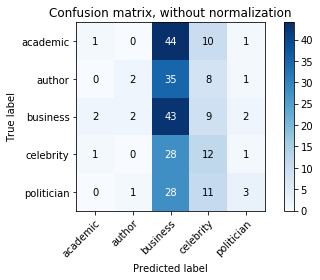

In [172]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
evaluation(y_test, knn.predict(X_test))
plot_confusion_matrix(y_test, knn.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

### Random Forest

classification report: 

              precision    recall  f1-score   support

           0       0.28      0.29      0.28        56
           1       0.24      0.24      0.24        46
           2       0.26      0.19      0.22        58
           3       0.18      0.24      0.20        42
           4       0.36      0.35      0.35        43

    accuracy                           0.26       245
   macro avg       0.26      0.26      0.26       245
weighted avg       0.26      0.26      0.26       245

Accuracy score: 0.2571428571428571
Confusion matrix, without normalization
[[16  7  8 19  6]
 [ 6 11  9 11  9]
 [21  7 11 11  8]
 [11  8  9 10  4]
 [ 4 12  6  6 15]]


/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


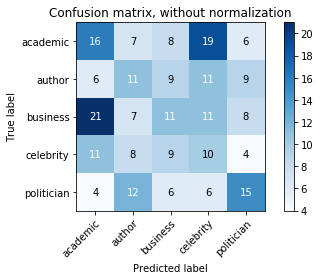

In [166]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
evaluation(y_test, rf.predict(X_test))
plot_confusion_matrix(y_test, rf.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

### SVM 

/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        58
           3       0.17      1.00      0.29        42
           4       0.00      0.00      0.00        43

    accuracy                           0.17       245
   macro avg       0.03      0.20      0.06       245
weighted avg       0.03      0.17      0.05       245

Accuracy score: 0.17142857142857143


/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[ 0  0  0 56  0]
 [ 0  0  0 46  0]
 [ 0  0  0 58  0]
 [ 0  0  0 42  0]
 [ 0  0  0 43  0]]


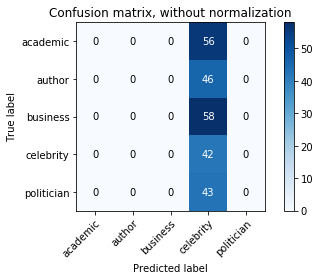

In [167]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
evaluation(y_test, svc.predict(X_test))
plot_confusion_matrix(y_test, svc.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

Overall, it seems like we need more information to classify these well; though I didn't tune the parameters, none of the models did much better than random guessing (which would put us at 20% accuracy)

## Feature Engineering -- Part II
Here, we get LDA topics (different from those found in nlp notebook -- corpus is smaller now, since some transcripts were dropped, and thus topics were lost), since some topics weren't hit upon) and use them as features. 

Putting together the dictionary...
Done! Getting topics...
Done! Word clouds:


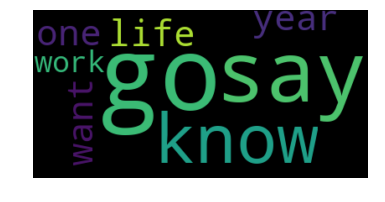

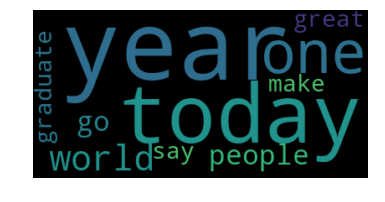

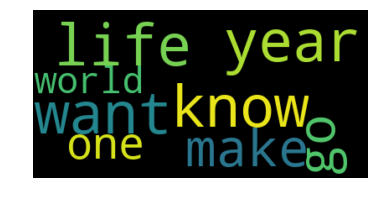

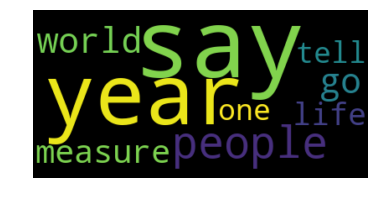

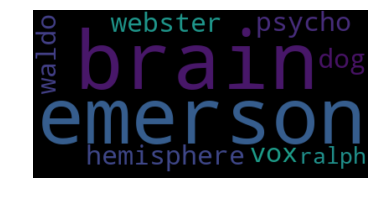

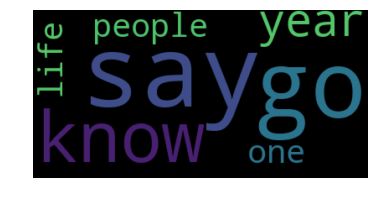

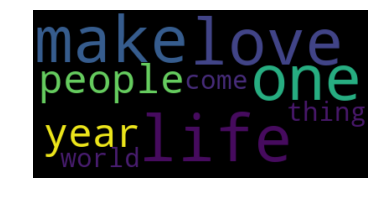

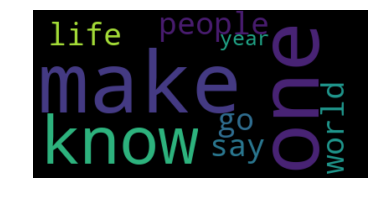

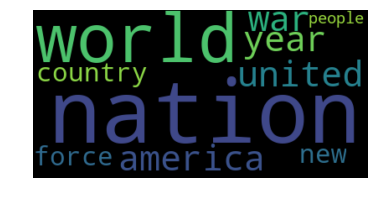

In [185]:
from gensim.corpora import Dictionary
from wordcloud import WordCloud
from gensim.models import LdaMulticore

# using my function frmo the nlp-eda notebook
def get_topics_and_wordclouds(corpus, n, random_state=10, chunksize=100, 
                             passes=10):
    """
    Uses LDA to get topics for a TOKENIZED corpus and plots associated word clouds.
    Returns the topics, if you need them.
    n: number of topics
    See Gensim LDA documentation for chunksize and passes description.
    (https://radimrehurek.com/gensim/models/ldamulticore.html)
    """
    print('Putting together the dictionary...')
    dictionary = Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    
    print('Done! Getting topics...')
    lda = LdaMulticore(doc_term_matrix, id2word=dictionary, num_topics=n, random_state = random_state,
                  chunksize=chunksize, passes=passes, per_word_topics=True)
    
    print('Done! Word clouds:')
    for i in range(n):
        wordcloud = WordCloud().generate(lda.print_topic(i))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
    return lda, dictionary

lda, dictionary = get_topics_and_wordclouds(data.processed.tolist(), 9)

In [186]:
topics = [lda.get_document_topics(dictionary.doc2bow(doc)) for doc in data.processed.tolist()]

In [196]:
def get_top_topic(doc):
    """
    get lda topic for test doc, then sort topics by probability and choose the 
    topic with the greatest probability
    select the 0th element of that topic (it's a tuple -- (index, probability) -- 
    and we only want the index)
    """
    topics = [x for x in lda.get_document_topics(dictionary.doc2bow(doc))]
    if len(topics) > 1:
        return sorted(topics, key=lambda x:x[1])[-1][0]
    else:
        return topics[0][0]
top_topic = [get_top_topic(doc) for doc in data.processed.tolist()]

In [198]:
# just get an idea of how topics are distributed over docments.
pd.Series(top_topic).value_counts()

0    383
1    303
7    250
8     49
5     32
2     18
6      9
3      6
4      1
dtype: int64

In [254]:
data_with_topics = pd.merge(left = pd.DataFrame(bow_transformed), 
                             right = pd.DataFrame(top_topic, columns=['topic']), 
                             left_index=True, right_index=True)
data_with_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,topic
0,7.742367,5.615670,9.014604,1.651930,0.550463,-0.374594,4.136744,-0.341877,-0.389831,-4.132078,...,-1.697209,1.212101,4.400329,1.317291,4.129070,3.422423,-0.583935,3.001629,-1.731753,7
1,5.975158,4.901978,4.595195,-1.098604,0.842186,1.900980,1.716820,0.627683,0.054764,-4.479969,...,-0.005105,-0.263344,1.343504,-1.075962,0.738177,-0.096954,-0.119857,2.594548,-2.723068,7
2,3.050403,2.729813,3.789214,-0.998580,0.414862,1.726297,0.679219,0.051754,-1.628872,-2.959606,...,-1.269542,-0.654121,0.131662,-0.118461,1.096801,-0.902586,-0.014228,1.709904,-1.013347,7
3,1.623408,0.909396,1.104082,-0.265826,0.039028,0.171308,0.676005,-0.554447,0.276766,-1.512373,...,-0.500683,-0.130197,-0.066049,0.292950,0.213132,-0.293801,-0.018196,0.065884,0.142089,0
4,7.265520,3.592638,4.802844,-4.145223,-1.296782,2.263225,1.753934,1.162906,-0.543905,-6.608895,...,-0.078489,1.310462,0.667685,-1.394949,2.790861,0.449099,-0.707359,2.829293,-0.421174,0


In [258]:
data_with_topic_dummies = pd.merge(left= data_with_topics, 
                                 right=pd.get_dummies(data_with_topics.topic), 
                                 left_index=True, right_index=True, 
                                   suffixes=('', '_topic') ).drop(columns=['topic'])

In [259]:
data_with_topic_dummies.head()

,0,1,2,3,4,5,6,7,8,9,...,37,0_topic,1_topic,2_topic,3_topic,4_topic,5_topic,6_topic,7_topic,8_topic
0,7.742367,5.615670,9.014604,1.651930,0.550463,-0.374594,4.136744,-0.341877,-0.389831,-4.132078,...,-1.731753,0,0,0,0,0,0,0,1,0
1,5.975158,4.901978,4.595195,-1.098604,0.842186,1.900980,1.716820,0.627683,0.054764,-4.479969,...,-2.723068,0,0,0,0,0,0,0,1,0
2,3.050403,2.729813,3.789214,-0.998580,0.414862,1.726297,0.679219,0.051754,-1.628872,-2.959606,...,-1.013347,0,0,0,0,0,0,0,1,0
3,1.623408,0.909396,1.104082,-0.265826,0.039028,0.171308,0.676005,-0.554447,0.276766,-1.512373,...,0.142089,1,0,0,0,0,0,0,0,0
4,7.265520,3.592638,4.802844,-4.145223,-1.296782,2.263225,1.753934,1.162906,-0.543905,-6.608895,...,-0.421174,1,0,0,0,0,0,0,0,0


Okay, I have my data -- ready to model again. Hopefully this will get us better results!

## Modeling (using count vectorizer features & LDA topics)
Again, we'll take a look at just a few of the basic models -- KNN, random forest, and SVM -- just to see how the classifiers fair.

### Preparing for modeling
Before modeling, we'll again have to split the data into a training group and testing group, and before that, scale it. Again, we'll take care of class imbalance.

In [260]:
# scaling 
scaler = MaxAbsScaler()
bow_scaled = scaler.fit_transform(data_with_topic_dummies)

# undersampling majority classes
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(bow_scaled, y)

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

classification report: 

              precision    recall  f1-score   support

           0       0.44      0.36      0.40        56
           1       0.33      0.43      0.38        46
           2       0.31      0.19      0.24        58
           3       0.33      0.38      0.35        42
           4       0.41      0.53      0.46        43

    accuracy                           0.37       245
   macro avg       0.37      0.38      0.37       245
weighted avg       0.37      0.37      0.36       245

Accuracy score: 0.3673469387755102
Confusion matrix, without normalization
[[20 15  6  4 11]
 [ 3 20  6 10  7]
 [11 13 11 15  8]
 [ 5  4 10 16  7]
 [ 6  8  2  4 23]]


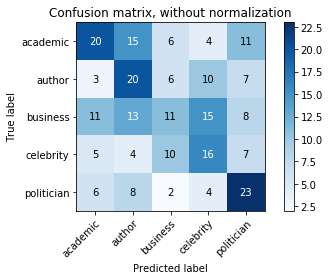

In [270]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
evaluation(y_test, knn.predict(X_test))
plot_confusion_matrix(y_test, knn.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

classification report: 

              precision    recall  f1-score   support

           0       0.45      0.45      0.45        56
           1       0.26      0.30      0.28        46
           2       0.29      0.24      0.26        58
           3       0.26      0.24      0.25        42
           4       0.43      0.49      0.46        43

    accuracy                           0.34       245
   macro avg       0.34      0.34      0.34       245
weighted avg       0.34      0.34      0.34       245

Accuracy score: 0.34285714285714286
Confusion matrix, without normalization
[[25 13  5  5  8]
 [ 4 14  7 11 10]
 [19 10 14  7  8]
 [ 5 12 13 10  2]
 [ 3  4  9  6 21]]


/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


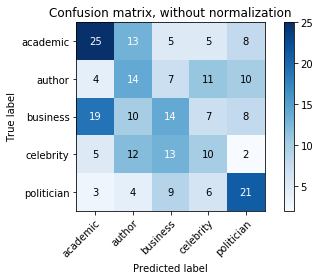

In [262]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
evaluation(y_test, rf.predict(X_test))
plot_confusion_matrix(y_test, rf.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

classification report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        58
           3       0.30      0.64      0.41        42
           4       0.22      0.79      0.34        43

    accuracy                           0.25       245
   macro avg       0.10      0.29      0.15       245
weighted avg       0.09      0.25      0.13       245

Accuracy score: 0.24897959183673468
Confusion matrix, without normalization
[[ 0  0  0 13 43]
 [ 0  0  0 17 29]
 [ 0  0  0 24 34]
 [ 0  0  0 27 15]
 [ 0  0  0  9 34]]


/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/hannah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


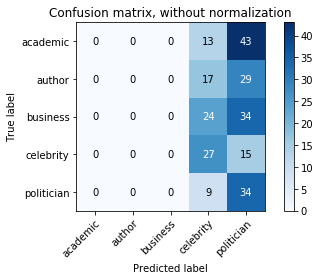

In [263]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
evaluation(y_test, svc.predict(X_test))
plot_confusion_matrix(y_test, svc.predict(X_test), 
                      le.inverse_transform([0, 1, 2, 3, 4]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

Okay! KNN got us 17% better than random guessing! Not amazing, but considering our limited data set and larger number of classes, it's not bad!